In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm
import tensorflow as tf

In [2]:
r = 0
T = 30/365

M = 2000
N = 30 

dt = T/N 
rdt = r*dt 

In [3]:
A0=1
sig_A=0.1
K_A= 1

B0=1
sig_B=0.2
K_B = 1

C0=1
sig_C=0.3
K_C = 1



In [4]:
def rainbow_max_call_payoff(s1,s2,s3,k1,k2,k3) :
  payoff_1 = max(s1-k1,0)
  payoff_2 = max(s2-k2,0)
  payoff_3 = max(s3-k3,0)
  rainbow_payoff = max(payoff_1,payoff_2,payoff_3)
  return rainbow_payoff

In [5]:
A = np.empty([M,N+1])
B = np.empty([M,N+1])
C = np.empty([M,N+1])
np.random.seed(1)
A_rv = np.random.normal(rdt, sig_A*np.sqrt(dt),[M,N])
np.random.seed(234)
B_rv = np.random.normal(rdt, sig_B*np.sqrt(dt),[M,N])
np.random.seed(5678)
C_rv = np.random.normal(rdt, sig_C*np.sqrt(dt),[M,N])


In [6]:
for i in range(M) :
  A[i,0] = A0
  for j in range(N) :
    A[i,j+1] = A[i,j] * ( 1 + A_rv[i,j])

In [7]:
np.shape(A)

(2000, 31)

In [8]:
for i in range(M) :
  B[i,0] = B0
  for j in range(N) :
    B[i,j+1] = B[i,j] * ( 1 + B_rv[i,j])

In [9]:
for i in range(M) :
  C[i,0] = C0
  for j in range(N) :
    C[i,j+1] = C[i,j] * ( 1 + C_rv[i,j])

In [10]:
rainbow_payoff =[]
for i in range(M) :
  rainbow_payoff.append(rainbow_max_call_payoff(A[i,-1],B[i,-1],C[i,-1],K_A,K_B,K_C))


In [11]:
mc_rainbow_premium = np.mean(rainbow_payoff) * np.exp(-r*T)
mc_rainbow_premium


0.053645008592891626

In [12]:
asset_price = []

for i in range(N+1) :
  asset_price.append(A[:,i])
  asset_price.append(B[:,i])
  asset_price.append(C[:,i])

In [13]:
np.shape(C)

(2000, 31)

In [14]:
asset_sum = A+B
asset_sum +=C


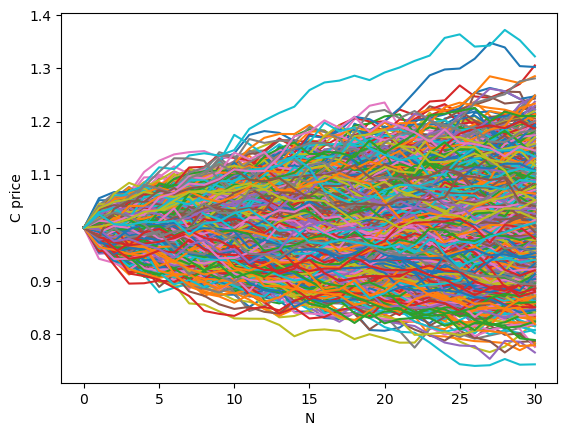

In [19]:
for i in range(M):
    plt.plot(C[i,:])
plt.xlabel('N')
plt.ylabel('C price')
plt.show()

In [16]:
np.shape(asset_sum)

(2000, 31)

In [17]:
input_data = []

hedge_cost = tf.keras.layers.Input(shape=(1,),name="hedge_cost")
premium = tf.keras.layers.Input(shape=(1,),name="premium")
price_A = tf.keras.layers.Input(shape=(1,),name="price_A")
price_B = tf.keras.layers.Input(shape=(1,),name='price_B')
price_C = tf.keras.layers.Input(shape=(1,),name='price_C')
input_data += [hedge_cost]
input_data += [premium]
input_data += [price_A]
input_data += [price_B]
input_data += [price_C]


for i in range(N) :
  delta_A = tf.keras.layers.Dense(24,activation='sigmoid')(price_A)
  delta_A = tf.keras.layers.BatchNormalization()(delta_A)
  delta_A = tf.keras.layers.Dense(16,activation="relu")(delta_A)
  delta_A = tf.keras.layers.Dense(16,activation="elu")(delta_A)
  delta_A = tf.keras.layers.Dense(8,activation="relu")(delta_A)
  delta_A = tf.keras.layers.BatchNormalization()(delta_A)
  delta_A = tf.keras.layers.Dense(6,activation='relu')(delta_A)
  delta_A = tf.keras.layers.BatchNormalization()(delta_A)
  delta_A = tf.keras.layers.Dense(3,activation="relu")(delta_A)
  delta_A = tf.keras.layers.Dense(1)(delta_A)

  delta_B = tf.keras.layers.Dense(24,activation='sigmoid')(price_B)
  delta_B = tf.keras.layers.BatchNormalization()(delta_B)
  delta_B = tf.keras.layers.Dense(16,activation="relu")(delta_B)
  delta_B = tf.keras.layers.BatchNormalization()(delta_B)
  delta_B = tf.keras.layers.Dense(8,activation="relu")(delta_B)
  delta_B = tf.keras.layers.BatchNormalization()(delta_B)
  delta_B= tf.keras.layers.Dense(6,activation='relu')(delta_B)
  delta_B = tf.keras.layers.BatchNormalization()(delta_B)
  delta_B= tf.keras.layers.Dense(3,activation="relu")(delta_B)
  delta_B= tf.keras.layers.Dense(1)(delta_B)

  delta_C = tf.keras.layers.Dense(24,activation='sigmoid')(price_C)
  delta_C = tf.keras.layers.BatchNormalization()(delta_C)
  delta_C = tf.keras.layers.Dense(16,activation="relu")(delta_C)
  delta_C = tf.keras.layers.BatchNormalization()(delta_C)
  delta_C = tf.keras.layers.Dense(8,activation="relu")(delta_C)
  delta_C = tf.keras.layers.BatchNormalization()(delta_C)
  delta_C = tf.keras.layers.Dense(6,activation='relu')(delta_C)
  delta_C = tf.keras.layers.BatchNormalization()(delta_C)
  delta_C = tf.keras.layers.Dense(3,activation="relu")(delta_C)
  delta_C = tf.keras.layers.Dense(1)(delta_C)


  new_price_A = tf.keras.layers.Input(shape=(1,),name="new_price_A"+str(i))
  input_data += [new_price_A]

  new_price_B = tf.keras.layers.Input(shape=(1,),name="new_price_B"+str(i))
  input_data += [new_price_B]

  new_price_C = tf.keras.layers.Input(shape=(1,),name="new_price_C"+str(i))
  input_data += [new_price_C]

  price_inc_A = tf.keras.layers.Subtract(name="price_inc_A"+str(i))([price_A,new_price_A])
  cost_A = tf.keras.layers.Multiply(name="multiply_A"+str(i))([delta_A, price_inc_A])
  price_A = new_price_A

  price_inc_B = tf.keras.layers.Subtract(name="price_inc_B"+str(i))([price_B,new_price_B])
  cost_B = tf.keras.layers.Multiply(name="multiply_B"+str(i))([delta_B, price_inc_B])
  price_B = new_price_B

  price_inc_C = tf.keras.layers.Subtract(name="price_inc_C"+str(i))([price_C,new_price_C])
  cost_C = tf.keras.layers.Multiply(name="multiply_C"+str(i))([delta_C, price_inc_C])
  price_C = new_price_C

  hedge_cost = tf.keras.layers.Add(name='cost_A'+str(i))([hedge_cost, cost_A])
  hedge_cost = tf.keras.layers.Add(name='cost_B'+str(i))([hedge_cost, cost_B])
  hedge_cost = tf.keras.layers.Add(name='cost_C'+str(i))([hedge_cost, cost_C])

payoff_A = tf.keras.layers.Lambda(lambda x : 0.5*(tf.abs(x-K_A)+x-K_A))(price_A)
payoff_B = tf.keras.layers.Lambda(lambda x : 0.5*(tf.abs(x-K_B)+x-K_B))(price_B)
payoff_C = tf.keras.layers.Lambda(lambda x : 0.5*(tf.abs(x-K_C)+x-K_C))(price_C)

payoff = tf.keras.layers.Maximum()([payoff_A,payoff_B,payoff_C])
cum_cost = tf.keras.layers.Add(name="final")([hedge_cost, payoff])
cum_cost = tf.keras.layers.Subtract(name="final_")([cum_cost, premium])

model = tf.keras.Model(inputs=input_data, outputs=cum_cost)

In [18]:
HC = np.zeros([M,1])
P = np.ones([M,1]) * mc_rainbow_premium
AP = asset_price

x = [HC]+[P]+[AP]
y = np.zeros([M,1])


In [19]:
model.compile(optimizer='adam',loss='mse')

In [20]:
model_history =model.fit(x,y, batch_size=128, epochs=1000,  verbose=True)

Epoch 1/1000
16/16 [==============================] - 197s 61ms/step - loss: 0.0077
Epoch 2/1000
16/16 [==============================] - 1s 57ms/step - loss: 0.0042
Epoch 3/1000
16/16 [==============================] - 1s 55ms/step - loss: 0.0029
Epoch 4/1000
16/16 [==============================] - 1s 55ms/step - loss: 0.0022
Epoch 5/1000
16/16 [==============================] - 1s 55ms/step - loss: 0.0017
Epoch 6/1000
16/16 [==============================] - 1s 57ms/step - loss: 0.0014
Epoch 7/1000
16/16 [==============================] - 1s 63ms/step - loss: 0.0012
Epoch 8/1000
16/16 [==============================] - 1s 61ms/step - loss: 0.0011
Epoch 9/1000
16/16 [==============================] - 1s 61ms/step - loss: 0.0010
Epoch 10/1000
16/16 [==============================] - 1s 60ms/step - loss: 9.3449e-04
Epoch 11/1000
16/16 [==============================] - 1s 60ms/step - loss: 8.2256e-04
Epoch 12/1000
16/16 [==============================] - 1s 62ms/step - loss: 7.7436e-04

63/63 [==============================] - 9s 15ms/step


(array([  2.,   4.,  17., 155., 475., 705., 445., 159.,  32.,   6.]),
 array([-0.06832695, -0.05592971, -0.04353248, -0.03113524, -0.018738  ,
        -0.00634076,  0.00605648,  0.01845372,  0.03085095,  0.04324819,
         0.05564543], dtype=float32),
 <BarContainer object of 10 artists>)

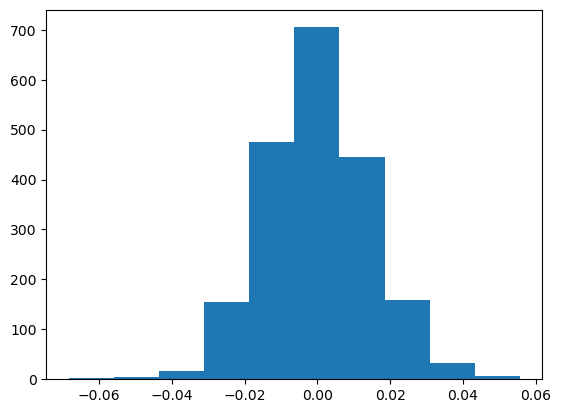

In [21]:
plt.hist(model.predict(x))

63/63 [==============================] - 1s 15ms/step


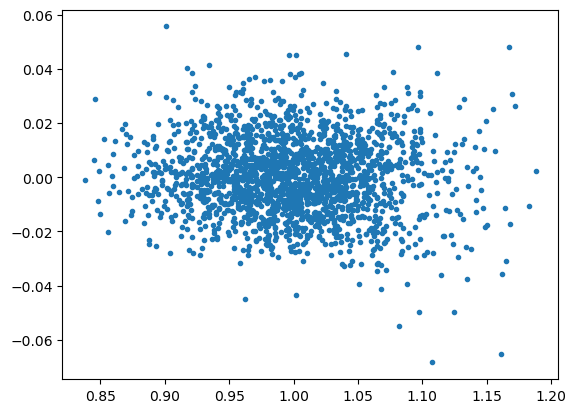

In [22]:
plt.plot( B[:,-1],model.predict(x),linestyle='none',marker=".")

In [23]:
np.mean(model.predict(x))

63/63 [==============================] - 1s 16ms/step


4.8253387e-05

(0.0, 0.001)

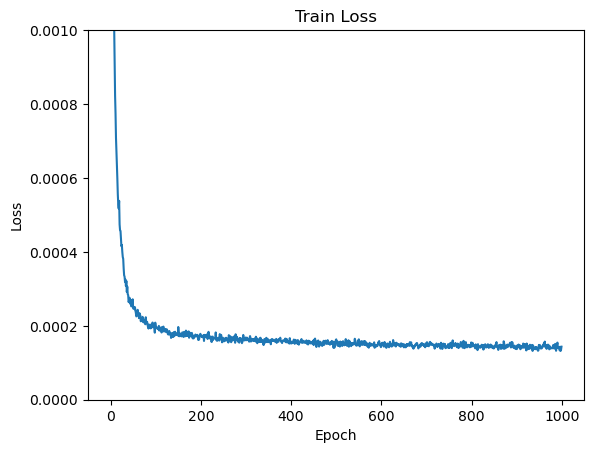

In [31]:
plt.plot(model_history.history['loss'])
plt.title('Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0,0.001)